## Building Agent with tools

In [1]:
# import all needed libraries
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage, ToolMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from IPython.display import Image,display
from dotenv import load_dotenv
import os
from typing import Literal
load_dotenv()
print("✅ All imports successful")


✅ All imports successful


In [2]:
# initilize LLM
llm= ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
print(f"✅ LLM initialized: {llm.model_name}")


✅ LLM initialized: gpt-4o-mini


### Creating the first tool

In [3]:
@tool
def calculator(expression:str)-> str:
     """
    Evaluate a mathematical expression and return the result.
    Use this tool when you need to perform calculations.
    
    Args:
        expression: A mathematical expression like "2 + 2" or "15 * 37"
       
    Returns:
        The calculated result as a string
        
    Examples:
        - "2 + 2" returns "4"
        - "100 / 5" returns "20.0"
        - "2 ** 10" returns "1024"
    """
     try:
        #   Evaluate the expression saftely
        result = eval(expression,{"__builtins__":{}},{})
        return str(result)
     except Exception as e:
        return f"Error Calculating:{str(e)}"
print("✅ Calculator tool created")


✅ Calculator tool created


In [4]:
# Test the calculator tool
result = calculator.invoke({"expression": "123 * 456"})
print(f"123 * 456 = {result}")

result2 = calculator.invoke("2 ** 10")
print(f"2^10 = {result2}")

123 * 456 = 56088
2^10 = 1024


In [5]:
@tool
def text_analyzer(text: str) -> str:
    """
    Analyze text and return statistics about it.
    Use this tool when you need to analyze or count things in text.
    
    Args:
        text: The text to analyze
        
    Returns:
        Statistics about the text (characters, words, sentences)
        
    Examples:
        - "Hello world" returns character count, word count, etc.
    """
    char_count = len(text)
    word_count = len(text.split())
    sentence_count = text.count('.') + text.count('!') + text.count('?')
    
    return f"""Text Analysis:
- Characters: {char_count}
- Words: {word_count}
- Sentences: {sentence_count}
- First 50 chars: {text[:50]}..."""

print("✅ Text analyzer tool created")

✅ Text analyzer tool created


In [6]:
# Test the text analyzer
test_text = "Hello! This is a test. How are you today?"
result = text_analyzer.invoke({"text": test_text})
print(result)

Text Analysis:
- Characters: 41
- Words: 9
- Sentences: 3
- First 50 chars: Hello! This is a test. How are you today?...


In [7]:
# word count analyzer
@tool
def text_finder(content:str, text:str) -> int:
    """"
    Count occurrences of a word/phrase in content (case-insensitive).
    Returns the count as a string.

    Args:
        context: the text to analyze
        text: the text to lookout for.

    returns: no of occurence of the text
    """
    import re
    if not text:
        return 0
    pattern = rf"\b{re.escape(text)}\b"
    count= len(re.findall(pattern,content, flags=re.IGNORECASE))
    return str(count)

In [8]:
context="I do not have your time. Abeg do not call me again. Not in your life say my name again. For the last time, do not ever in your life call my sister as well"
text="not"
counter = text_finder.invoke({"content": context, "text": text})
print(f"{text} found {counter} times")

not found 4 times


### Now we need to tell the LLM about our tools.

In [9]:
tools=[calculator,text_analyzer,text_finder]
# bind d tools with llm
llm_with_tools= llm.bind_tools(tools)
print(f"✅ LLM bound to {len(tools)} tools")
print(f"   Tools: {[tool.name for tool in tools]}")

✅ LLM bound to 3 tools
   Tools: ['calculator', 'text_analyzer', 'text_finder']


In [10]:
# Test: Does LLM decide to call calculator?
response = llm_with_tools.invoke([HumanMessage(content="What is multiplication of 234 and 567?")])

print(f"Response type: {type(response)}")
print(f"\nContent: {response.content}")
print(f"\nTool calls: {response.tool_calls}")

Response type: <class 'langchain_core.messages.ai.AIMessage'>

Content: 

Tool calls: [{'name': 'calculator', 'args': {'expression': '234 * 567'}, 'id': 'call_x5g5T1xSBEG9q7E4MAFaq5XB', 'type': 'tool_call'}]


In [11]:
# Test: Does LLM decide NOT to call tools for simple queries?
response2 = llm_with_tools.invoke([HumanMessage(content="Hello! How are you?")])

print(f"Content: {response2.content}")
print(f"Tool calls: {response2.tool_calls}")

Content: Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?
Tool calls: []


### Now let's build a complete agent that can use these tools.

In [12]:
# System prompt that encourages tool usage
sys_msg = SystemMessage(content="""You are a helpful assistant with access to tools.

When asked to perform calculations, use the calculator tool.
When asked to analyze text, use the text_analyzer tool.

Only use tools when necessary - for simple questions, answer directly.""")

def assistant(state: MessagesState) -> dict:
    """
    Assistant node - decides whether to use tools or answer directly.
    """
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

print("✅ Assistant node defined")

✅ Assistant node defined


In [13]:
# Let define the conditional routing
def should_continue(state:MessagesState)-> Literal["tools","__end__"]:
    """Decide next step based on last message.
    
    if LLM called a tool-> go to 'tools' node
    if LLM provided final answer -> go to END"""
    last_message= state["messages"][-1]

    # check if LLM made tool calls
    if last_message.tool_calls:
        return "tools"
    
    # No tool call: we are done
    return "__end__"
print("✅ Conditional routing function defined")

✅ Conditional routing function defined


### Build the Graph

In [14]:
# define builder
builder = StateGraph(HumanMessage)

# adding nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# adding edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", should_continue, {"tools":"tools","__end__":END})
builder.add_edge("tools", "assistant")

# Add memory
memory= MemorySaver()
agent= builder.compile(checkpointer=memory)


### Visualize the Graph

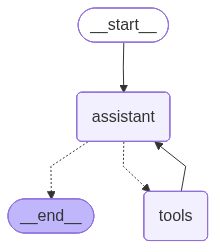

In [15]:
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure: START → assistant → [conditional] → tools → assistant → END")

### Testing the Tool-Using Agent

In [16]:
# Helper function
def run_agent(user_input: str, thread_id: str = "test_session"):
    """
    Run the agent and display the conversation.
    """
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")
    
    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )
    
    for message in result["messages"]:
        if isinstance(message, HumanMessage):
            continue  # Already printed
        elif isinstance(message, AIMessage):
            if message.tool_calls:
                print(f"🤖 Agent: [Calling tool: {message.tool_calls[0]['name']}]")
            else:
                print(f"🤖 Agent: {message.content}")
        elif isinstance(message, ToolMessage):
            print(f"🔧 Tool Result: {message.content[:100]}..." if len(message.content) > 100 else f"🔧 Tool Result: {message.content}")
    
    print(f"\n{'='*70}\n")

print("✅ Test function ready")

✅ Test function ready


In [19]:
# testing calculator tool
run_agent("What is multiplication of 12345 by 67890?", thread_id="user1")


👤 User: What is multiplication of 12345 by 67890?



TypeError: 'NoneType' object is not subscriptable

In [ ]:
run_agent("Analyze this text: 'RAG systems combine retrieval with generation. They are very useful!'")